# Earthquake Data Analysis

### Description

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes in about 20 years of recording in South California. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* **Waiting time (t)**: time interval between an event and the next one in the sequence.
* **Distance (r)**: Eucledian 3D distance between events. (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake)


### Assignments

1. Deduce what is the variable in each column of the catalog.
2. Visualize the process in space and/or time with suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or a nice linear combination of coordinates) as a function of time.
3. Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.
4. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.
5. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)
6. Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 5 is considered) on a single curve?

### Datasets

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

Joining each event to that with the index of the second column (if not -1), there emerges a set of causal trees.


### Contact
* Marco Baiesi <marco.baiesi@unipd.it>

In [1]:
import pandas as pd

data = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#filepath = '/content/drive/MyDrive/LCP_project/'

In [3]:
#df = pd.read_csv(filepath + data, sep = ' ', names = ['Index', 'Prev event', 'Time', 'Magnitude', 'x', 'y', 'z'])
df = pd.read_csv(data, sep = ' ', names = ['Index', 'Prev_event', 'Time', 'Magnitude', 'x', 'y', 'z'])

df.head(5)

,Index,Prev_event,Time,Magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In [ ]:
df.tail(5)
df

# Graphical Part

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(2, 3, 1, projection='3d')
scatter1 = ax1.scatter(df['x'], df['y'], df['z'], c=df['Time'], cmap='viridis', marker='.')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
fig.colorbar(scatter1, label='Time', shrink=0.7)

ax2 = fig.add_subplot(2, 3, 2)
scatter2 = ax2.scatter(df['x'], df['y'], c=df['z'], cmap='inferno', marker='.')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(scatter2, label='Depth', shrink=0.7)

ax3 = fig.add_subplot(2, 3, 3)
scatter3 = ax3.scatter(df['x'], df['y'], c=df['Time'], cmap='viridis', marker='.')
fig.colorbar(scatter3, label='Time', shrink=0.7)

ax4 = fig.add_subplot(2, 3, 4, projection='3d')
scatter4 = ax4.scatter(df['x'], df['y'], df['z'], c=df['Time'], cmap='viridis', marker='.')
fig.colorbar(scatter4, label='Time', shrink=0.7)

ax5 = fig.add_subplot(2, 3, 5)
scatter5 = ax5.scatter(df['x'], df['y'], c=df['z'], cmap='inferno', marker='.')
fig.colorbar(scatter5, label='Depth', shrink=0.7)

ax6 = fig.add_subplot(2, 3, 6)
scatter6 = ax6.scatter(df['x'], df['y'], c=df['Time'], cmap='viridis', marker='.')
fig.colorbar(scatter6, label='Time', shrink=0.7)

# andamento chiaro della dipendenza della depth da longitude e latitude, inefficacia del primo plot perchè non c'è una
# dipendenza temporale definita dalla posizione dell'ipocentro

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import plotly.express as px
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import numpy.linalg as la

In [ ]:
# AGGIUNTA COLONNE PER I DATI AGGIUNTIVI: Waiting time, Distance, lat, lon, dep
df['Waiting time prev'] = df['Index']
df['Distances prev'] = df['Index']
df['Waiting time'] = df['Index']
df['Distances'] = df['Index']

for i in range(np.shape(df)[0]):
  if df['Prev_event'][i] == -1:
    Time_1 = df['Time'][i]
    Distance_1 = np.array([df['x'][i], df['y'][i], df['z'][i]])
  elif df['Prev_event'][i] > -1:
    Time_1 = df['Time'][df['Prev_event'][i]]
    Distance_1 = np.array([df['x'][df['Prev_event'][i]], df['y'][df['Prev_event'][i]], df['z'][df['Prev_event'][i]]])

  df['Waiting time prev'][i] = df['Time'][i] - Time_1
  df['Distances prev'][i] = math.sqrt(np.sum((np.array([df['x'][i], df['y'][i], df['z'][i]]) - Distance_1)**2))


for i in range(np.shape(df)[0]):
  if df['Index'][i] == 0:
    Time_1 = df['Time'][i]
    Distance_1 = np.array([df['x'][i], df['y'][i], df['z'][i]])
  elif df['Index'][i] > -0:
    Time_1 = df['Time'][i-1]
    Distance_1 = np.array([df['x'][i-1], df['y'][i-1], df['z'][i-1]])

  df['Waiting time'][i] = df['Time'][i] - Time_1
  df['Distances'][i] = math.sqrt(np.sum((np.array([df['x'][i], df['y'][i], df['z'][i]]) - Distance_1)**2))

R = 6371000 # m
df['r'] = df['Index']
for i in range(np.shape(df)[0]):
  df['r'][i] = (df['x'][i]**2 + df['y'][i]**2 + df['z'][i]**2)**0.5

df['lat'] = np.arcsin(df['z'] / df['r'])*180/math.pi
df['lon'] = np.arctan2(df['y'], df['x'])*180/math.pi
df['dep'] = df['r'] - R

df

In [ ]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
scatter1 = ax1.scatter(df['x'], df['y'], df['z'], c=df['dep'], cmap='inferno_r', marker='.')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.view_init(0,30)
fig.colorbar(scatter1, label='depth', shrink=0.5)

ax2 = fig.add_subplot(1, 3, 2)
scatter2 = ax2.scatter(df['x'], df['y'], c=df['dep'], cmap='inferno_r', marker='.')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect(aspect=1)
fig.colorbar(scatter2, label='depth', shrink=0.7)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
scatter3 = ax3.scatter(df['x'], df['y'], df['z'], c=df['dep'], cmap='inferno_r', marker='.')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.view_init(0,150)
fig.colorbar(scatter3, label='depth', shrink=0.5)

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
scatter1 = ax1.scatter(df['lon'], df['lat'], df['dep'], c=df['dep'], cmap='inferno_r', marker='.')
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_zlabel('depth')
ax1.view_init(20,90)
fig.colorbar(scatter1, label='depth', shrink=0.5)

ax2 = fig.add_subplot(1, 3, 2)
scatter2 = ax2.scatter(df['lon'], df['lat'], c=df['dep'], cmap='inferno_r', marker='.')
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.set_aspect(aspect=1)
fig.colorbar(scatter2, label='depth', shrink=0.7)

df_mag4 = df[df['Magnitude'] > 4]
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
scatter3 = ax3.scatter(df_mag4['lon'], df_mag4['lat'], df_mag4['dep'], c=df_mag4['dep'], cmap='inferno_r', marker='.')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
ax3.set_zlabel('depth')
ax3.set_title('Magnitude > 4')
ax3.view_init(20,90)
fig.colorbar(scatter3, label='depth', shrink=0.5)

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
scatter1 = ax1.scatter(df['x'], df['y'], df['z'], c=np.log(df['Waiting time']), cmap='viridis', marker='.')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.view_init(0,30)
fig.colorbar(scatter1, label='Waiting time log', shrink=0.5)

ax2 = fig.add_subplot(1, 3, 2)
scatter2 = ax2.scatter(df['x'], df['y'], c=np.log(df['Waiting time']), cmap='viridis', marker='.')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect(aspect=1)
fig.colorbar(scatter2, label='Waiting time log', shrink=0.7)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
scatter3 = ax3.scatter(df['x'], df['y'], df['z'], c=df['Time'], cmap='viridis', marker='.')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.view_init(0,30)
fig.colorbar(scatter3, label='Time', shrink=0.5)

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
scatter1 = ax1.scatter(df['lon'], df['lat'], df['dep'], c=np.log(df['Waiting time']), cmap='viridis', marker='.')
ax1.set_xlabel('longtude')
ax1.set_ylabel('latitude')
ax1.set_zlabel('depth')
ax1.view_init(20,90)
fig.colorbar(scatter1, label='Waiting time log', shrink=0.5)

ax2 = fig.add_subplot(1, 3, 2)
scatter2 = ax2.scatter(df['lon'], df['lat'], c=np.log(df['Waiting time']), cmap='viridis', marker='.')
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.set_aspect(aspect=1)
fig.colorbar(scatter2, label='Waiting time log', shrink=0.7)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
scatter3 = ax3.scatter(df['lon'], df['lat'], df['dep'], c=df['Time'], cmap='viridis', marker='.')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
ax3.set_zlabel('depth')
ax3.view_init(20,90)
fig.colorbar(scatter3, label='Time', shrink=0.5)

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(2, 3, 1, projection='3d')
scatter1 = ax1.scatter(df['x'], df['y'], df['z'], c=df['Magnitude'], cmap='plasma', marker='.', vmin=np.min(df.Magnitude), vmax=np.max(df.Magnitude))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.view_init(0,30)
fig.colorbar(scatter1, label='Magnitude', shrink=0.5)

ax2 = fig.add_subplot(2, 3, 2)
scatter2 = ax2.scatter(df['x'], df['y'], c=np.log(df['Magnitude']), cmap='plasma', marker='.', vmin=np.min(np.log(df.Magnitude)), vmax=np.max(np.log(df.Magnitude)))
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect(aspect=1)
fig.colorbar(scatter2, label='Magnitude log', shrink=0.7)

df_mag3 = df[df['Magnitude'] > 3]
ax3 = fig.add_subplot(2, 3, 3, projection='3d')
scatter3 = ax3.scatter(df_mag3['x'], df_mag3['y'], df_mag3['z'], c=np.log(df_mag3['Magnitude']), cmap='plasma', marker='.', vmin=np.min(np.log(df.Magnitude)), vmax=np.max(np.log(df.Magnitude)))
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.view_init(0,30)
fig.colorbar(scatter3, label='Magnitude log > 3', shrink=0.5)

df_mag4 = df[df['Magnitude'] > 4]
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
scatter4 = ax4.scatter(df_mag4['x'], df_mag4['y'], df_mag4['z'], c=df_mag4['Magnitude'], cmap='plasma', marker='.', vmin=np.min(df.Magnitude), vmax=np.max(df.Magnitude))
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('z')
ax4.view_init(0,30)
fig.colorbar(scatter4, label='Magnitude > 4', shrink=0.5)

ax5 = fig.add_subplot(2, 3, 5)
scatter5 = ax5.scatter(df_mag4['x'], df_mag4['y'], c=np.log(df_mag4['Magnitude']), cmap='plasma', marker='.', vmin=np.min(np.log(df.Magnitude)), vmax=np.max(np.log(df.Magnitude)))
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_aspect(aspect=1)
fig.colorbar(scatter5, label='Magnitude log > 4', shrink=0.7)

df_mag6 = df[df['Magnitude'] > 6]
ax6 = fig.add_subplot(2, 3, 6, projection='3d')
scatter6 = ax6.scatter(df_mag6['x'], df_mag6['y'], df_mag6['z'], c=df_mag6['Magnitude'], cmap='plasma', marker='o', alpha=0.8, vmin=np.min(df.Magnitude), vmax=np.max(df.Magnitude))
ax6.set_xlabel('x')
ax6.set_ylabel('y')
ax6.set_zlabel('z')
ax6.view_init(0,30)
fig.colorbar(scatter6, label='Magnitude log > 6', shrink=0.5)

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(2, 3, 1, projection='3d')
scatter1 = ax1.scatter(df['lon'], df['lat'], df['dep'], c=df['Magnitude'], cmap='plasma', marker='.', vmin=np.min(df.Magnitude), vmax=np.max(df.Magnitude))
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_zlabel('depth')
ax1.view_init(20,90)
fig.colorbar(scatter1, label='Magnitude', shrink=0.5)

ax2 = fig.add_subplot(2, 3, 2)
scatter2 = ax2.scatter(df['lon'], df['lat'], c=np.log(df['Magnitude']), cmap='plasma', marker='.', vmin=np.min(np.log(df.Magnitude)), vmax=np.max(np.log(df.Magnitude)))
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.set_aspect(aspect=1)
fig.colorbar(scatter2, label='Magnitude log', shrink=0.7)

df_mag3 = df[df['Magnitude'] > 3]
ax3 = fig.add_subplot(2, 3, 3, projection='3d')
scatter3 = ax3.scatter(df_mag3['lon'], df_mag3['lat'], df_mag3['dep'], c=np.log(df_mag3['Magnitude']), cmap='plasma', marker='.', vmin=np.min(np.log(df.Magnitude)), vmax=np.max(np.log(df.Magnitude)))
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
ax3.set_zlabel('depth')
ax3.view_init(20,90)
fig.colorbar(scatter3, label='Magnitude log > 3', shrink=0.5)

df_mag4 = df[df['Magnitude'] > 4]
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
scatter4 = ax4.scatter(df_mag4['lat'], df_mag4['lon'], df_mag4['dep'], c=df_mag4['Magnitude'], cmap='plasma', marker='.', vmin=np.min(df.Magnitude), vmax=np.max(df.Magnitude))
ax4.set_xlabel('longitude')
ax4.set_ylabel('latitude')
ax4.set_zlabel('depth')
ax4.view_init(20,90)
fig.colorbar(scatter4, label='Magnitude > 4', shrink=0.5)

ax5 = fig.add_subplot(2, 3, 5)
scatter5 = ax5.scatter(df_mag4['lon'], df_mag4['lat'], c=np.log(df_mag4['Magnitude']), cmap='plasma', marker='.', vmin=np.min(np.log(df.Magnitude)), vmax=np.max(np.log(df.Magnitude)))
ax5.set_xlabel('longitude')
ax5.set_ylabel('latitude')
ax5.set_aspect(aspect=1)
fig.colorbar(scatter5, label='Magnitude log > 4', shrink=0.7)

df_mag6 = df[df['Magnitude'] > 6]
ax6 = fig.add_subplot(2, 3, 6, projection='3d')
scatter6 = ax6.scatter(df_mag6['lon'], df_mag6['lat'], df_mag6['dep'], c=df_mag6['Magnitude'], cmap='plasma', marker='o', alpha=0.8, vmin=np.min(df.Magnitude), vmax=np.max(df.Magnitude))
ax6.set_xlabel('longitude')
ax6.set_ylabel('latitude')
ax6.set_zlabel('depth')
ax6.view_init(20,90)
fig.colorbar(scatter6, label='Magnitude log > 6', shrink=0.5)

plt.tight_layout()

In [ ]:
df_0 = df[df['Prev_event'] > 0]
df_1 = df[df['Prev_event'] == 0]
print(np.shape(df_0))

fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1_1 = ax1.scatter(df_0['x'], df_0['y'], df_0['z'], c=df_0['Prev_event'], cmap='rainbow', marker='.')
scatter1_2 = ax1.scatter(df_1['x'], df_1['y'], df_1['z'], c='black', marker='.')
fig.colorbar(scatter1_1, label='Prev_event', shrink=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.view_init(0,30)

ax2= fig.add_subplot(1, 2, 2, projection='3d')
scatter2_1 = ax2.scatter(df_0['lon'], df_0['lat'], df_0['dep'], c=df_0['Prev_event'], cmap='rainbow', marker='.')
scatter2_2 = ax2.scatter(df_1['lon'], df_1['lat'], df_1['dep'], c='black', marker='.')
fig.colorbar(scatter2_1, label='Prev_event', shrink=0.5)
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.set_zlabel('depth')
ax2.view_init(20,90)

plt.tight_layout()

In [ ]:
ax1 = px.scatter_mapbox(df, lat=df.lat, lon=df.lon, color=df.Magnitude, width=600, height=500, opacity=0.5, color_continuous_scale='plasma',
                        center=dict(lat=32, lon=-117), zoom=4, title='Interactive map of the South California earthquakes',
                        mapbox_style='open-street-map')
ax1.show()

ax2 = px.scatter_mapbox(df, lat=df.lat, lon=df.lon, color=df.dep, width=600, height=500, opacity=0.5, color_continuous_scale='inferno_r',
                        center=dict(lat=32, lon=-117), zoom=4, title='Interactive map of the South California earthquakes',
                        mapbox_style='open-street-map')
ax2.show()

In [ ]:
df['Animation_frame'] = np.round(200*(df['Time']/df['Time'].max()))

In [ ]:
ax1 = px.scatter_mapbox(df, lat=df.lat, lon=df.lon, color=df.Magnitude, width=600, height=500, opacity=1, color_continuous_scale='plasma', range_color=[df.Magnitude.min(), df.Magnitude.max()],
                        center=dict(lat=33.5, lon=-117), zoom=4, title='Interactive map of the South California earthquakes', animation_frame=df.Animation_frame,
                        mapbox_style='open-street-map')
ax1.show()

ax2 = px.scatter_mapbox(df, lat=df.lat, lon=df.lon, color=df.dep, width=600, height=500, opacity=1, color_continuous_scale='inferno_r', range_color=[df.dep.min(), df.dep.max()],
                        center=dict(lat=33.5, lon=-117), zoom=4, title='Interactive map of the South California earthquakes', animation_frame=df.Animation_frame,
                        mapbox_style='open-street-map')
ax2.show()

In [ ]:
sns.jointplot(df, x=df.lon, y=df.lat, kind='hist')

In [ ]:
sns.kdeplot(df, x=df.lon, y=df.lat, fill=True, thresh=0, levels=10, cmap='rocket_r')

In [ ]:
sns.jointplot(df, x=df.dep, y=df.Magnitude, kind='hist')

In [ ]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,3,1)
ax1.plot(df.Time, df.Index, label='Time vs Index')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(df.Time, df.Magnitude, label='Time vs Magnitude')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(df.Time, df.Magnitude, label='Time vs Magnitude')

# PCA

In [ ]:
PCA_array = np.array(df)[:, 4:7]
print(np.shape(PCA_array))

C = np.cov(PCA_array.T)
sns.heatmap(C)

In [ ]:
U, spectrum, Vt = la.svd(PCA_array[:10000].T)

In [ ]:
l_svd = spectrum**2/(np.shape(df)[0]+1)
V_svd = U

print('Autovalori\t', l_svd/C.trace())
print('Autovettore\t', V_svd[:,0])

In [ ]:
array_newbasis = np.array([la.solve(U, PCA_array[i, :]) for i in range(np.shape(PCA_array)[0])])

In [ ]:
np.shape(array_newbasis)

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1, projection='3d')

plt.scatter(array_newbasis[:,0], array_newbasis[:,1], array_newbasis[:,2])

# Resolution (beta)

In [ ]:
#Versione 1
import numpy as np

m = [2, 3, 4, 5]

fig, ax = plt.subplots(1, 4, figsize = (14,7))

for j, i in enumerate(m):
      df2 = df[df['Magnitude'] >= i].sort_values(by = 'Time')
      wt = np.diff(df2['Time'])
      wt[wt<1.e-5] = 1.e-6
      #x = np.logspace(np.log10(np.min(wt)), np.log10(np.max(wt)), 50)
      x = np.linspace(np.min(wt), np.max(wt), 75)
      print(np.min(x), np.max(x))
      print(np.min(wt), np.max(wt))
      
      ax[j].hist(wt, bins = x, edgecolor = 'black')
      #ax[j].set_xscale('log', base = 10)
      ax[j].set_yscale('log', base = 10)
      
plt.show()

In [ ]:
#Versione 2

m = [2, 3, 4, 5]

fig, ax = plt.subplots(1, 4, figsize = (14,7))

for j, i in enumerate(m):
      df2 = df[df['Magnitude'] >= i].sort_values(by = 'Time')
      wt = df2["Time"].diff().to_numpy()
      wt = wt[wt<1.e6]
      x = np.logspace(np.log10(10), np.log10(np.max(wt)), 50)
      #x = np.linspace(np.min(wt), np.max(wt), 75)
      print(np.min(x), np.max(x))
      print(np.min(wt), np.max(wt))
      
      ax[j].hist(wt, bins = x, edgecolor = 'black')
      ax[j].set_xscale('log', base = 10)
      ax[j].set_yscale('log', base = 10)
      
plt.show()

In [ ]:
plt.plot(df['Time'], df['Index'])
plt.show()

In [ ]:
df

In [ ]:
#np.linalg.norm(x2-x1)

fig, ax = plt.subplots(1, 4, figsize = (14,7))

for j, i in enumerate(m):
      df2 = df[df['Magnitude'] >= i][['x', 'y', 'z']]
      coordinates = df2.to_numpy()
      dd = np.linalg.norm(np.diff(coordinates, axis = 0), axis = 1)
      print(dd.shape)
      
      #x = np.logspace(np.log10(np.min(wt)), np.log10(np.max(wt)), 50)
      x = np.linspace(np.min(dd), np.max(dd), 75)
      ax[j].hist(dd, bins = x, edgecolor = 'black')
      #ax[j].set_xscale('log', base = 10)
      #ax[j].set_yscale('log', base = 10)
      
plt.show()

# Point 3. Distributions of waiting times

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.optimize import curve_fit


First we define the functions we need for data analysis and plots.

The `log_plot` function sets up all parameters we need for plotting histogram in log-log scale:

* To select number of bins, we use the Scott formula: $$N_{\text{bins}}\simeq\frac{3.49\sigma}{n^{\frac{1}{3}}}$$ where $\sigma$ is the standard deviation and $n$ is the number of samples.  
To avoid having too few bins for future regressions, though, we choose a minimum number of bins equal to $10$.

* We generate an equally logarithmically spaced set of points using `np.logspace()` specifying the number of bins we calculated before

* After evaluating bin centers and bin widths we normalize the histogram in order to give a statistical meaning to the distribution.

* We get rid of the empty bins in order for us to be able to evaluate the errors propagating the Poisson error of the unnormalized histogram.

* The function returns the bin centers, the counts per bin and the errors (all in logarithmic scale).

In [5]:
def log_plot(feature):
    
    #Excluding zeros
    feature = feature[feature != 0]
    
    #Bin edges (in logarithmic scale)
    n_bins = max([np.histogram_bin_edges(np.log10(feature), bins = 'auto').shape[0] - 1, 10])
    
    x = np.logspace(np.log10(feature.min()), np.log10(feature.max()), base = 10, num = n_bins)
    
    #Histogram data
    hist = np.histogram(feature, bins = x)
    bin_centers = (hist[1][1:] + hist[1][:-1]) / 2
    bin_widths = hist[1][1:] - hist[1][:-1]
    
    #Normalization of the histogram
    norm = np.sum(hist[0])
    counts_normalized = hist[0] / (bin_widths * norm)
    
    #Clean of empty bins
    mask = (counts_normalized > 0)
    counts_normalized = counts_normalized[mask]
    bin_centers = bin_centers[mask]
    
    bins = np.log10(bin_centers)
    counts = np.log10(counts_normalized)
    errors = np.log10(np.e) / np.sqrt(hist[0][mask])
    
    return bins, counts, errors

As discussed later, we use `cut_tails` function to proper select the linearly distributed points (in log-log scale):

* For the left side we first arbitraly drop off all data points a given threshold

* Then, for both sides we recursively compare the pearson coefficient with the one we would obtain getting rid off of the extreme point: if the new value is better than the previous one we reject that point, otherwise we stop the algorithm.

* The function returns bin centers, counts per bin, errors and the pearson coefficients list.

In [6]:
def cut_tails(b, c, e, threshold):
    
    c = c[b >= threshold]
    e = e[b >= threshold]
    b = b[b >= threshold] 
    
    pearson = [0]
    
    while True:
        new_p = np.corrcoef(b[:-1], y = c[:-1])[0,1]
        if(new_p > pearson[-1] or len(b) <= 9):
            break
        b = b[:-1]
        c = c[:-1]
        e = e[:-1]
        pearson.append(new_p)
        
    while True:
        new_p = np.corrcoef(b[1:], y = c[1:])[0,1]
        if(new_p > pearson[-1] or len(b) <= 9):
            break
        b = b[1:]
        c = c[1:]
        e = e[1:]
        pearson.append(new_p)
        
    return b, c, e, pearson

The `statistic_plots` function allows us to perform a linear regression on the given feature and to evaluate the $\chi^2$.

In [7]:
f_lin = lambda x, m, q: m*x+q

def statistic_plots(bins, counts, magnitudes, errors, feature, spec = ''):
    fit_res = []

    fig, ax = plt.subplots(2, len(magnitudes), figsize = (14, 6))

    for i, (x, y, m, e) in enumerate(zip(bins, counts, magnitudes, errors)):

        #Linear regression
        (slope, intercept), pcov = curve_fit(f_lin, x, y, sigma=e, absolute_sigma=True)
        
        #Residuals
        residuals = y - (slope*x+intercept)
        chisquare = np.sum((residuals/e)**2)
        dof = x.shape[0]-2 #degrees of freedom of the chisquare
        fit_res.append((slope, intercept, pcov, chisquare, dof))

        #Plot
        x_axis = np.linspace(x.min(), x.max(), 100)
        ax[0,i].scatter(x, y, label="Data points")
        ax[0,i].plot(x_axis, (slope * x_axis) + intercept, color = 'darkred', label = 'Fit')
        ax[0,i].set_ylabel(f"$\log(P_{m}({feature})$)")
        ax[0,i].set_xlabel(f"$\log({feature})$")
        ax[0,i].grid()

        #Residual plot
        ax[1,i].errorbar(x, residuals, yerr = e, fmt = 'o', capsize = 2.5, label="Residual")
        ax[1,i].hlines(0,x.min(), x.max(), color='darkred', label = 'Fit')
        ax[1,i].grid()

    ax[0,-1].legend()
    ax[1,-1].legend()
    fig.suptitle('Linear regressions and residuals' + spec, fontsize = 18)
    plt.tight_layout()
    plt.show()
    
    return fit_res

As features we need waiting times, that we can get by applying the `diff()` function to the 'Time' column of dataframe starting from the second row.

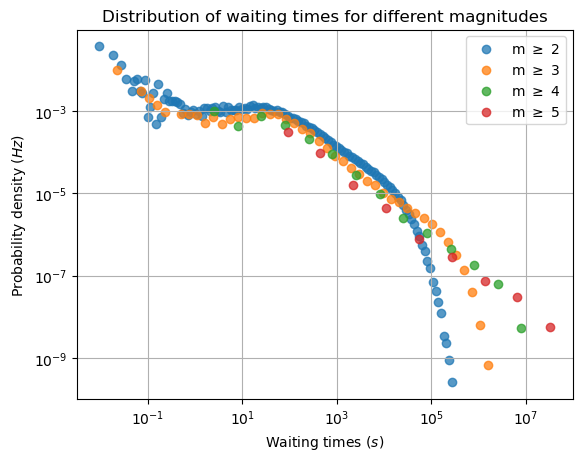

In [8]:
#Inizializing lists
magnitudes = [2, 3, 4, 5]
bins = []
counts = []
errors = []

for i, m in enumerate(magnitudes):
    
    #Array of waiting times
    wt = np.array(df[df['Magnitude'] >= m][['Time']].sort_values('Time').diff())[1:]
    
    #Prepare data for plot
    b, c, e = log_plot(wt)
    bins.append(b)
    counts.append(c)
    errors.append(e)
    
    #Plot
    plt.scatter(10 ** b, 10 ** c, alpha = 0.75, label = f"m $\geq$ {m}")
    plt.xscale('log', base = 10)
    plt.yscale('log', base = 10)
    
plt.xlabel('Waiting times ($s$)')
plt.ylabel('Probability density ($Hz$)')
plt.title('Distribution of waiting times for different magnitudes')
plt.legend()
plt.grid()
plt.show()

Now we can apply the `cut_tails()` function in order to select only the linear regime of the distributions.

In [9]:
pearson_list = []

for i, m in enumerate(magnitudes):
    
    bins[i], counts[i], errors[i], pearson = cut_tails(bins[i], counts[i], errors[i], threshold = 2)
    pearson_list.append(pearson[-1])

Finally, we perform the linear regression and visualize both the fit and residuals.

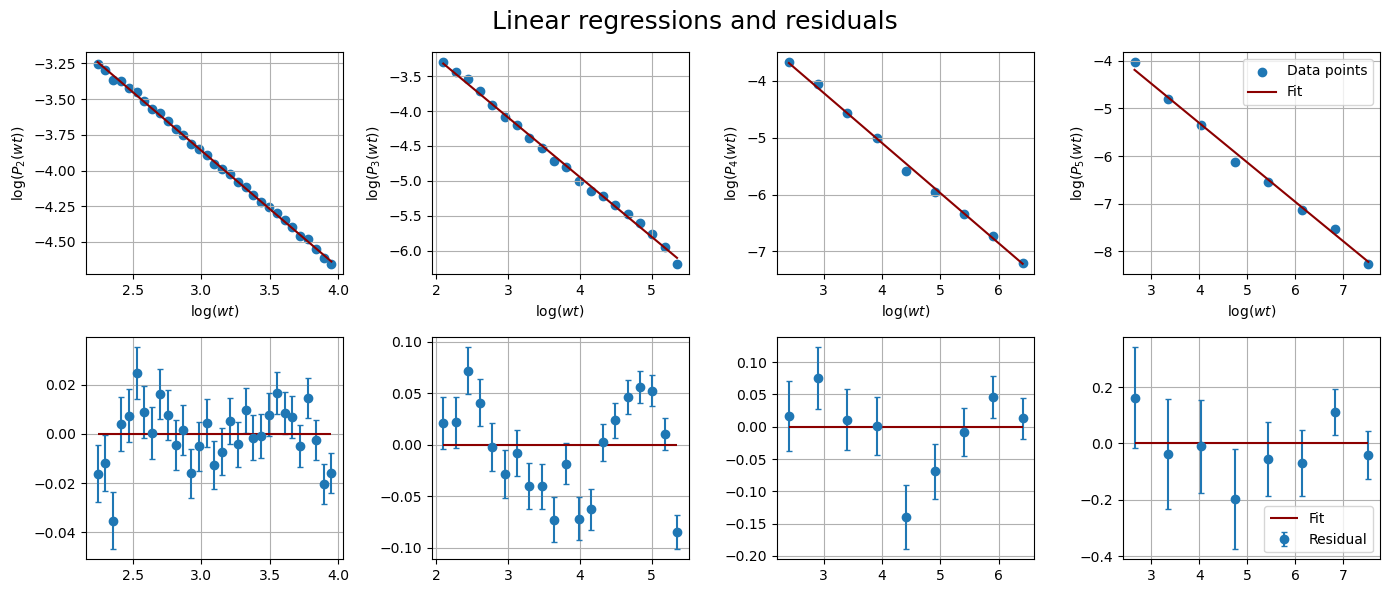

In [10]:
fit_res = statistic_plots(bins, counts, magnitudes, errors, 'wt')

We display the results of the linear fit and perform a $\chi^2$ goodness of fit test.

In [11]:
for res, m, p in zip(fit_res, magnitudes, pearson_list):
    slope, intercept, pcov, chisquare , dof = res
    confidence_level = (1.- chi2.cdf(chisquare, dof))*100
    
    sigma_slope, sigma_intercept = np.sqrt(np.diag(pcov))
    
    print(f"------ Earthquakes with magnitude m ≥ {m}  ------")
    print(f"Slope: {slope:.3f} ± {sigma_slope:.3f}")
    print(f"Intercept: {intercept:.3f} ± {sigma_intercept:.3f}")
    print(f"Pearson coefficient: {p:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Chi2: {chisquare:.2f}")
    print(f"Hypotesis accepted with confidence level {confidence_level:.1f}%")
    print()

------ Earthquakes with magnitude m ≥ 2  ------
Slope: -0.817 ± 0.003
Intercept: -1.411 ± 0.011
Pearson coefficient: -1.00
Degrees of freedom: 29
Chi2: 49.34
Hypotesis accepted with confidence level 1.1%

------ Earthquakes with magnitude m ≥ 3  ------
Slope: -0.854 ± 0.004
Intercept: -1.529 ± 0.019
Pearson coefficient: -1.00
Degrees of freedom: 18
Chi2: 118.94
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with magnitude m ≥ 4  ------
Slope: -0.882 ± 0.011
Intercept: -1.565 ± 0.053
Pearson coefficient: -1.00
Degrees of freedom: 7
Chi2: 15.53
Hypotesis accepted with confidence level 3.0%

------ Earthquakes with magnitude m ≥ 5  ------
Slope: -0.827 ± 0.029
Intercept: -1.996 ± 0.181
Pearson coefficient: 0.00
Degrees of freedom: 6
Chi2: 4.72
Hypotesis accepted with confidence level 58.0%



# 4. Distributions of distances

We repeat what we did in the previous point for the distances between two consecutive measurement.

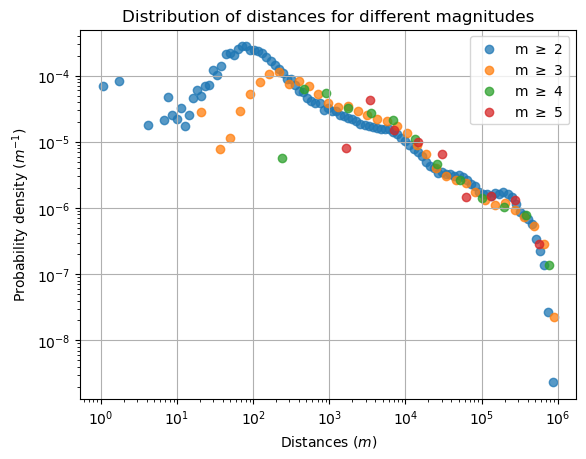

In [12]:
bins   = []
counts = []
errors = []

for i, m in enumerate(magnitudes):
      #Array of siatcnes
      df2 = df[df['Magnitude'] >= m].sort_values('Time')[['x', 'y', 'z']]
      coordinates = df2.to_numpy()
      dd = np.linalg.norm(np.diff(coordinates, axis = 0), axis = 1)
      
      #Prepare data for plot
      b, c, e = log_plot(dd)
      bins.append(b)
      counts.append(c)
      errors.append(e)
      
      #Plot
      plt.scatter(10 ** b, 10 ** c, alpha = 0.75, label = f"m $\geq$ {m}")
      plt.xscale('log', base = 10)
      plt.yscale('log', base = 10)
      
plt.xlabel('Distances ($m$)')
plt.ylabel('Probability density ($m^{-1}$)')
plt.title('Distribution of distances for different magnitudes')
plt.legend()
plt.grid()
plt.show()

In [13]:
pearson_list = []

for i, m in enumerate(magnitudes):
    
    bins[i], counts[i], errors[i], pearson = cut_tails(bins[i], counts[i], errors[i], threshold = 2)
    pearson_list.append(pearson[-1])

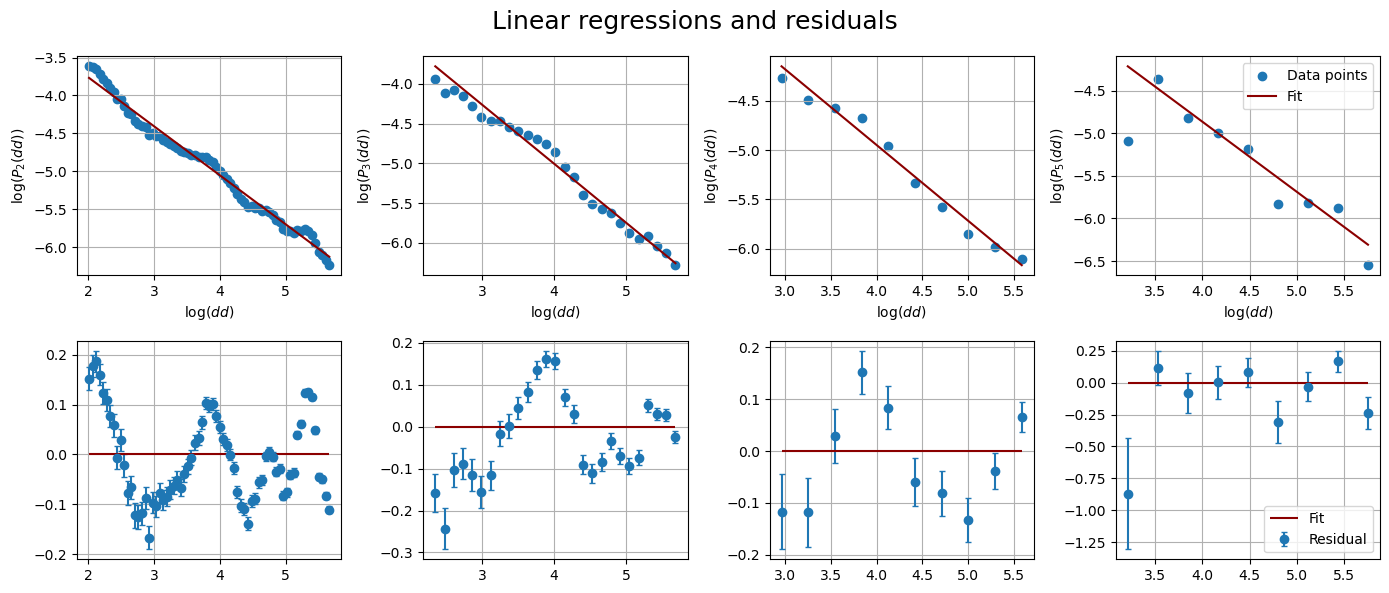

In [14]:
fit_res = statistic_plots(bins, counts, magnitudes, errors, 'dd')

We display the results of the linear fit and perform a $\chi^2$ Goodness of Fit Test

In [15]:
for res, m, p in zip(fit_res, magnitudes, pearson_list):
    slope, intercept, pcov, chisquare , dof = res
    confidence_level = (1.- chi2.cdf(chisquare, dof))*100
    
    sigma_slope, sigma_intercept = np.sqrt(np.diag(pcov))
    
    print(f"------ Earthquakes with magnitude m ≥ {m}  ------")
    print(f"Slope: {slope:.3f} ± {sigma_slope:.3f}")
    print(f"Intercept: {intercept:.3f} ± {sigma_intercept:.3f}")
    print(f"Pearson coefficient: {p:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Chi2: {chisquare:.2f}")
    print(f"Hypotesis accepted with confidence level {confidence_level:.1f}%")
    print()

------ Earthquakes with magnitude m ≥ 2  ------
Slope: -0.646 ± 0.002
Intercept: -2.468 ± 0.007
Pearson coefficient: -0.99
Degrees of freedom: 67
Chi2: 3431.04
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with magnitude m ≥ 3  ------
Slope: -0.739 ± 0.005
Intercept: -2.049 ± 0.022
Pearson coefficient: -0.99
Degrees of freedom: 25
Chi2: 424.71
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with magnitude m ≥ 4  ------
Slope: -0.767 ± 0.017
Intercept: -1.881 ± 0.080
Pearson coefficient: -0.99
Degrees of freedom: 8
Chi2: 44.49
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with magnitude m ≥ 5  ------
Slope: -0.824 ± 0.058
Intercept: -1.569 ± 0.279
Pearson coefficient: 0.00
Degrees of freedom: 7
Chi2: 16.85
Hypotesis accepted with confidence level 1.8%



# 5. Distributions of waiting times in different domains of magnitudes and relative distances

We construct a function  - called `get_Pmr()` - that, for a given value of magnitude $m$ and relative distance $R$, selects the events having magnitude $\geqslant m$ and relative distances $\leqslant R$; finally, it computes the waiting times.

In [16]:
def get_Pmr(df, m, R): 
    
    dfm = df[df['Magnitude']>= m].sort_values('Time')[['Time', 'x', 'y', 'z']]
    
    #Evaluate the distance between one event and the next one 
    coordinates = dfm.to_numpy()
    dd = np.linalg.norm(np.diff(coordinates, axis = 0), axis = 1)
    dd = np.insert(dd, 0, 0)
    
    dfm['Rel_distance'] = dd
    dfmr = dfm[dfm['Rel_distance'] <= R].sort_values('Time') #Select by distance 
    
    wt = np.array(dfmr['Time'].diff())[1:]
    
    return dfmr, dd, wt

Now we can plot the results using two nested cycles: with the outer one we select the magnitude and the inner one the relative distance.

In contrast to the previous calculations we excluded the highest magnitude $m=5$ because the plot resulted into being too unpopulated.

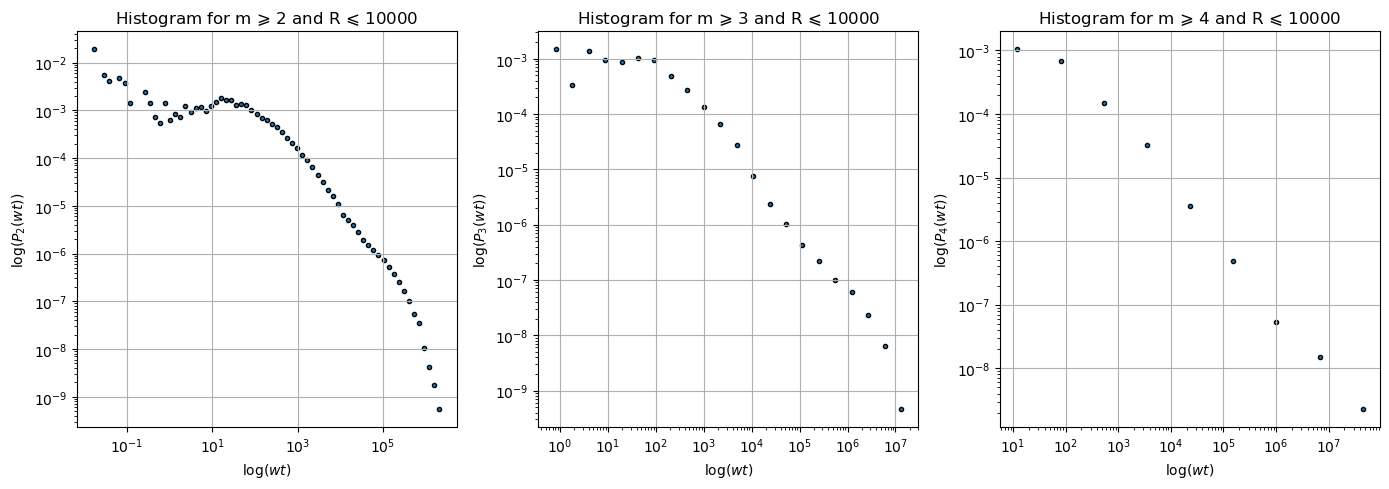

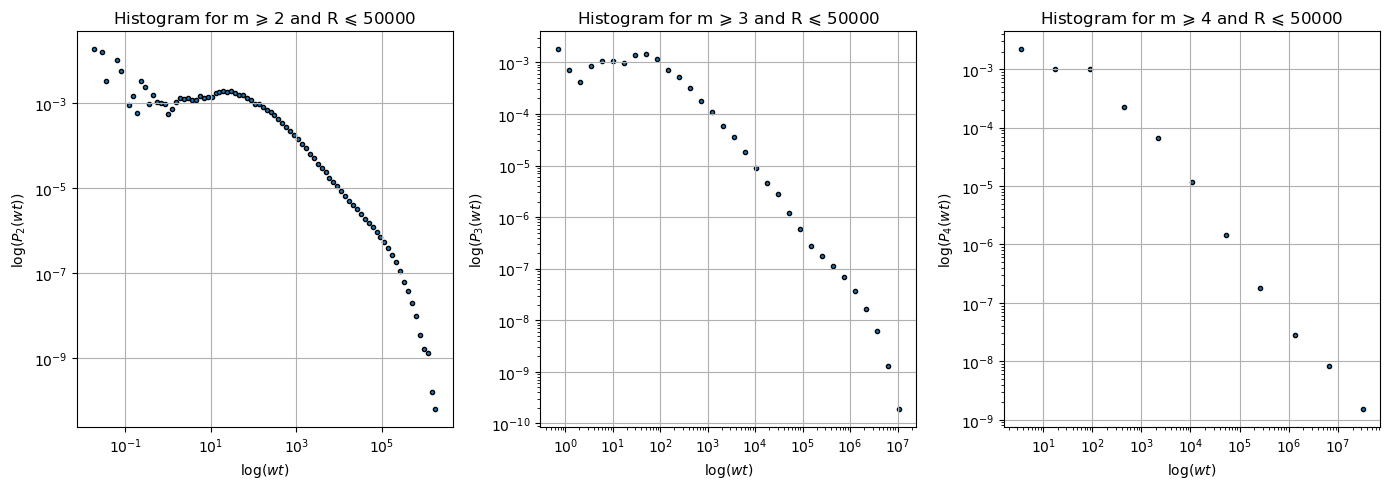

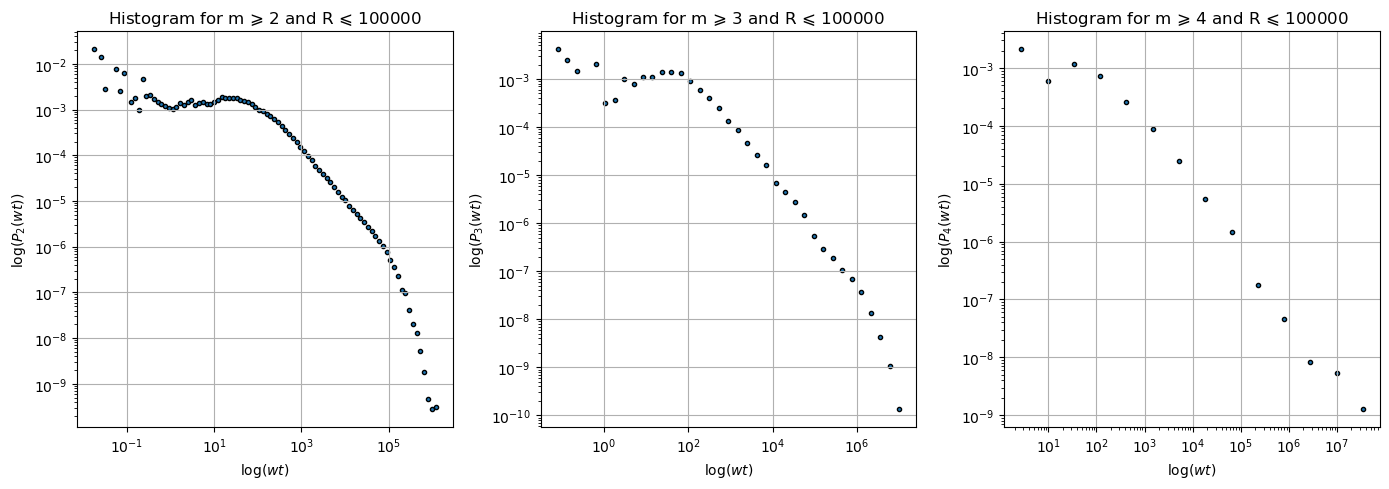

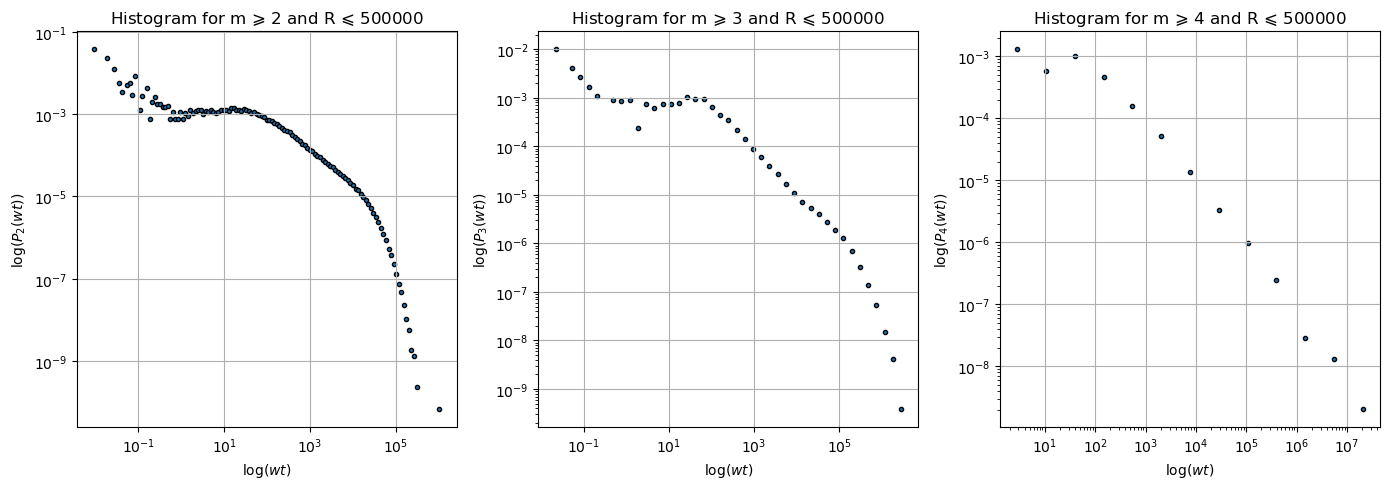

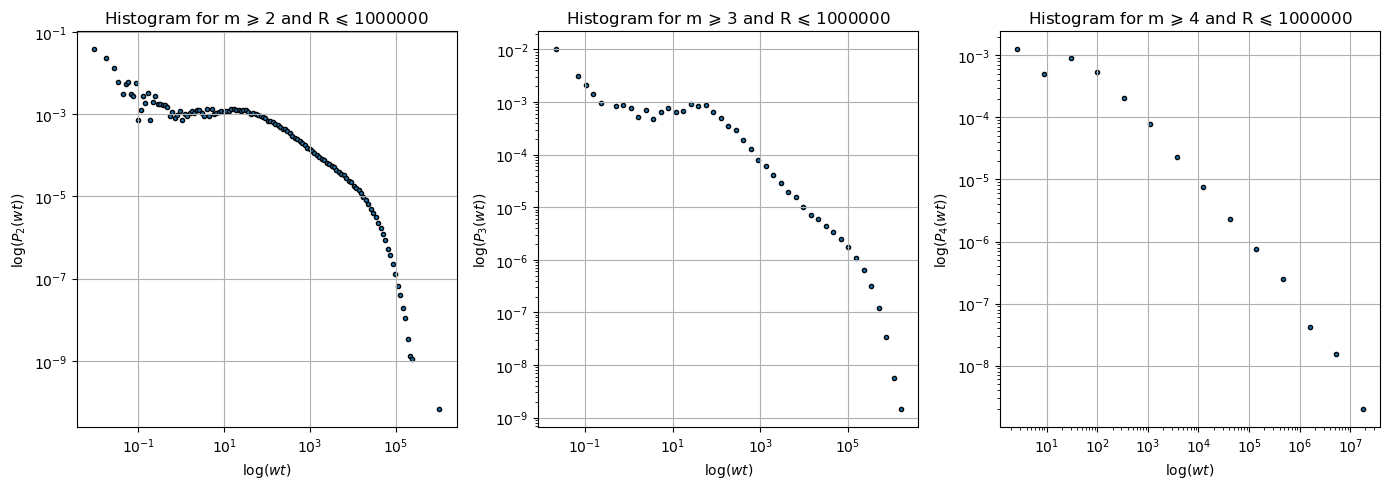

In [17]:
magnitudes = [2, 3, 4]
Radii = [1e4, 5e4, 1e5, 5e5, 1e6]

bins   = [[] for _ in range(len(Radii))]
counts = [[] for _ in range(len(Radii))]
errors = [[] for _ in range(len(Radii))]

for j, radius in enumerate(Radii):
    index = 0
    fig, ax = plt.subplots(1, len(magnitudes), figsize = (14,5))
    
    for i, m in enumerate(magnitudes):
        dfmr, dd, wt = get_Pmr(df, m, radius)
        
        b, c, e = log_plot(wt)
        bins[j].append(b)
        counts[j].append(c)
        errors[j].append(e)
        
        ax[index].scatter(10 ** b, 10 ** c, edgecolor = 'black', marker = '.')
        ax[index].set_title(f'Histogram for m $\geqslant$ {m} and R $\leqslant$ {radius:.0f}')
        ax[index].set_yscale('log', base = 10)
        ax[index].set_xscale('log', base = 10)
        
        ax[index].set_ylabel(f"$\log(P_{m}(wt)$)")
        ax[index].set_xlabel(f"$\log(wt)$")
        ax[index].grid()
        
        index += 1

    plt.tight_layout()
    
plt.show()

In [18]:
pearson_list = []

for i, m in enumerate(magnitudes):
    for j, radius in enumerate(Radii):
        bins[j][i], counts[j][i], errors[j][i], pearson = cut_tails(bins[j][i], counts[j][i], errors[j][i], threshold = 2)
        pearson_list.append(pearson[-1])

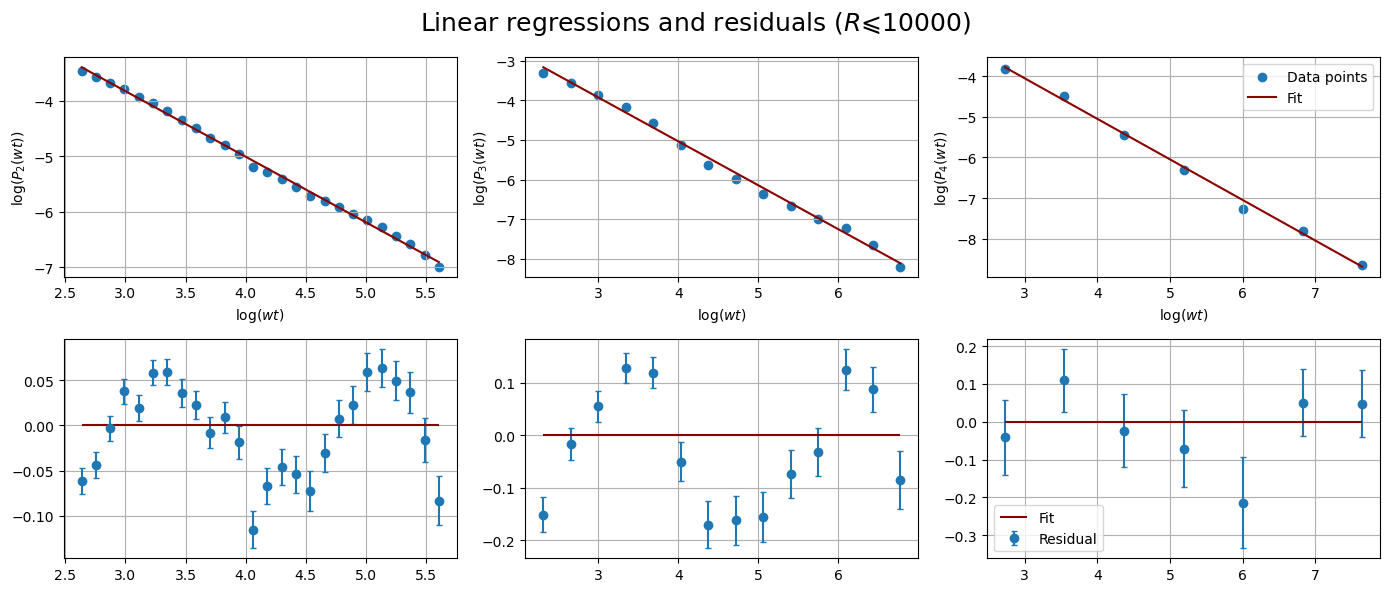

------ Earthquakes with m ≥ 2, R ≤ 10000.0  ------
Slope: -1.180 ± 0.004
Intercept: -0.290 ± 0.016
Pearson coefficient: -1.00
Degrees of freedom: 24
Chi2: 183.19
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with m ≥ 3, R ≤ 10000.0  ------
Slope: -1.108 ± 0.007
Intercept: -0.604 ± 0.032
Pearson coefficient: -1.00
Degrees of freedom: 12
Chi2: 119.22
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with m ≥ 4, R ≤ 10000.0  ------
Slope: -0.998 ± 0.021
Intercept: -1.062 ± 0.116
Pearson coefficient: -1.00
Degrees of freedom: 5
Chi2: 6.19
Hypotesis accepted with confidence level 28.8%



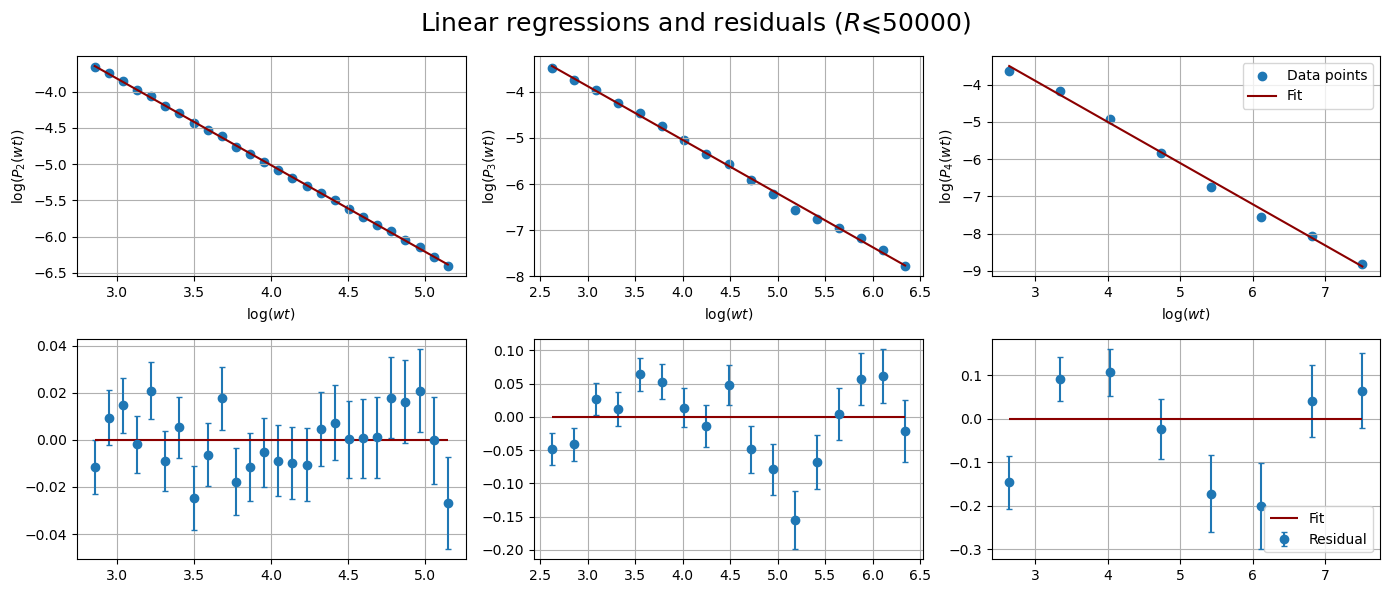

------ Earthquakes with m ≥ 2, R ≤ 50000.0  ------
Slope: -1.191 ± 0.004
Intercept: -0.249 ± 0.016
Pearson coefficient: -1.00
Degrees of freedom: 24
Chi2: 21.17
Hypotesis accepted with confidence level 62.9%

------ Earthquakes with m ≥ 3, R ≤ 50000.0  ------
Slope: -1.164 ± 0.007
Intercept: -0.384 ± 0.029
Pearson coefficient: -1.00
Degrees of freedom: 15
Chi2: 48.34
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with m ≥ 4, R ≤ 50000.0  ------
Slope: -1.105 ± 0.016
Intercept: -0.582 ± 0.076
Pearson coefficient: -1.00
Degrees of freedom: 6
Chi2: 21.56
Hypotesis accepted with confidence level 0.1%



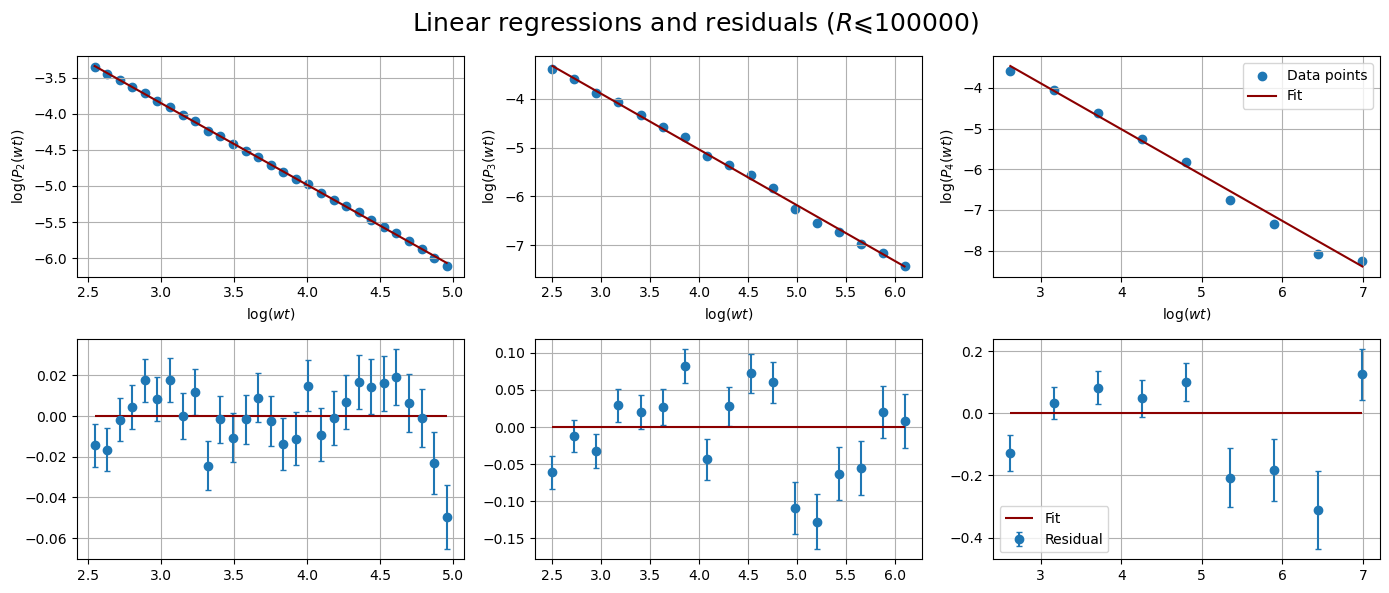

------ Earthquakes with m ≥ 2, R ≤ 100000.0  ------
Slope: -1.133 ± 0.003
Intercept: -0.450 ± 0.012
Pearson coefficient: -1.00
Degrees of freedom: 27
Chi2: 40.03
Hypotesis accepted with confidence level 5.1%

------ Earthquakes with m ≥ 3, R ≤ 100000.0  ------
Slope: -1.141 ± 0.006
Intercept: -0.476 ± 0.026
Pearson coefficient: -1.00
Degrees of freedom: 15
Chi2: 69.11
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with m ≥ 4, R ≤ 100000.0  ------
Slope: -1.127 ± 0.018
Intercept: -0.511 ± 0.077
Pearson coefficient: -1.00
Degrees of freedom: 7
Chi2: 27.50
Hypotesis accepted with confidence level 0.0%



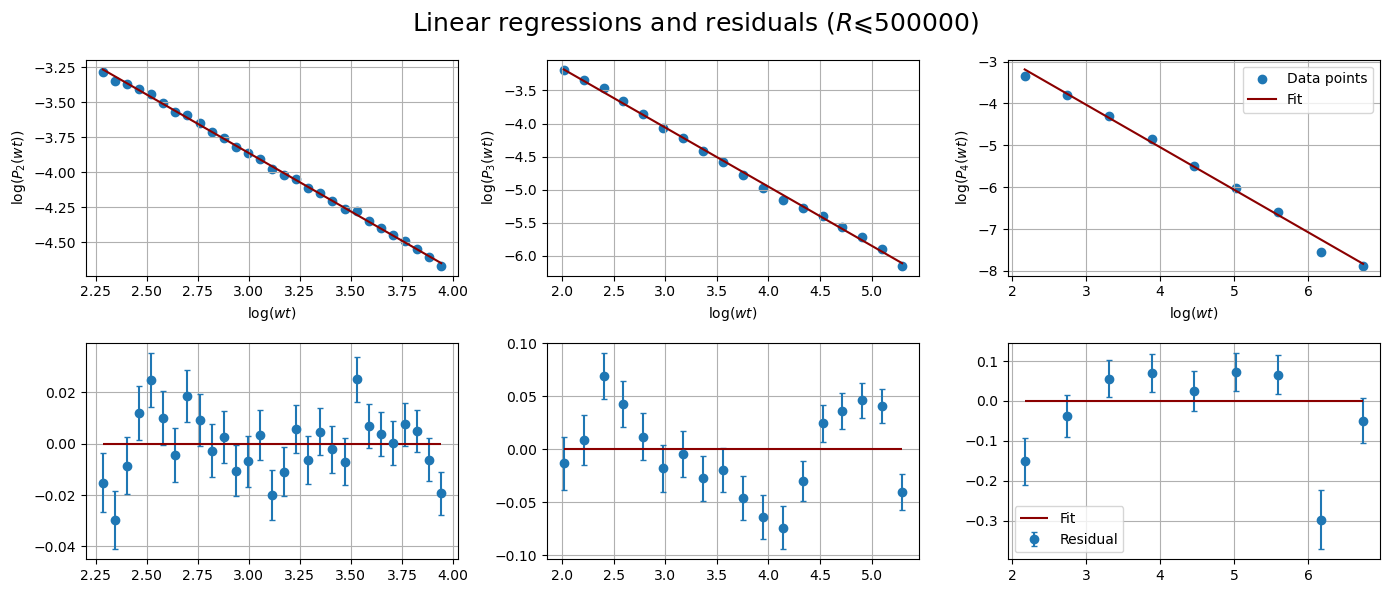

------ Earthquakes with m ≥ 2, R ≤ 500000.0  ------
Slope: -0.837 ± 0.004
Intercept: -1.352 ± 0.012
Pearson coefficient: -1.00
Degrees of freedom: 27
Chi2: 46.55
Hypotesis accepted with confidence level 1.1%

------ Earthquakes with m ≥ 3, R ≤ 500000.0  ------
Slope: -0.892 ± 0.005
Intercept: -1.386 ± 0.019
Pearson coefficient: -1.00
Degrees of freedom: 16
Chi2: 73.72
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with m ≥ 4, R ≤ 500000.0  ------
Slope: -1.016 ± 0.013
Intercept: -0.984 ± 0.058
Pearson coefficient: -1.00
Degrees of freedom: 7
Chi2: 31.87
Hypotesis accepted with confidence level 0.0%



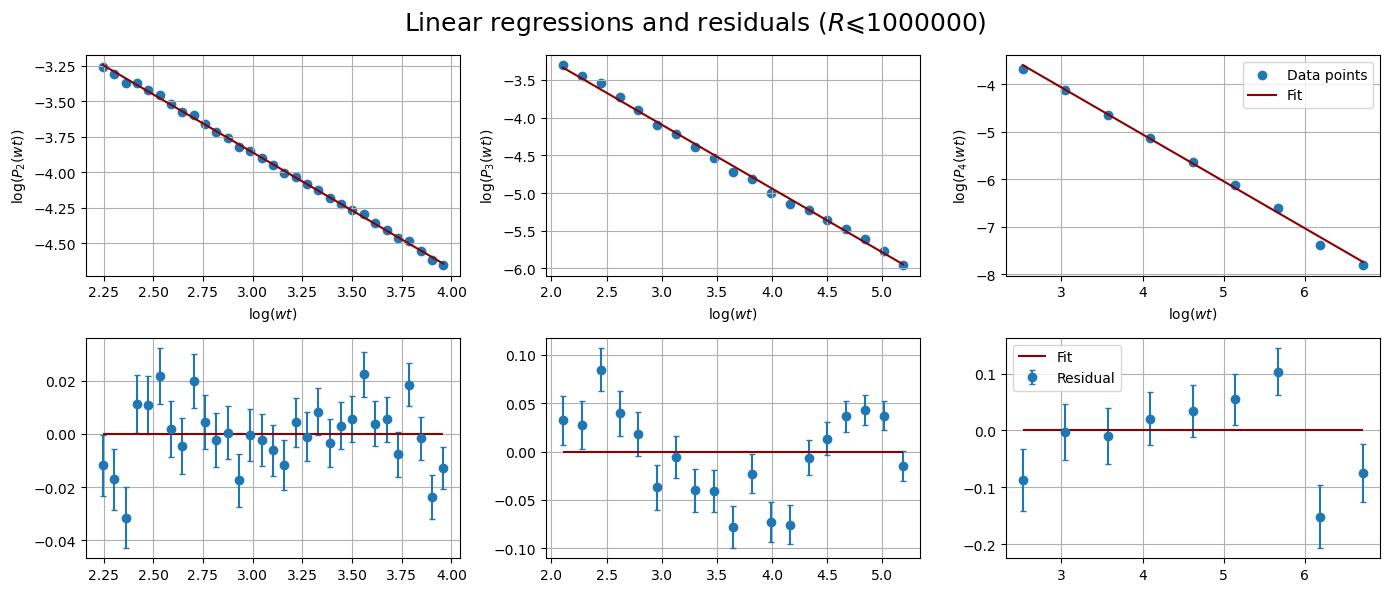

------ Earthquakes with m ≥ 2, R ≤ 1000000.0  ------
Slope: -0.817 ± 0.003
Intercept: -1.408 ± 0.011
Pearson coefficient: -1.00
Degrees of freedom: 29
Chi2: 52.80
Hypotesis accepted with confidence level 0.4%

------ Earthquakes with m ≥ 3, R ≤ 1000000.0  ------
Slope: -0.846 ± 0.005
Intercept: -1.554 ± 0.019
Pearson coefficient: -1.00
Degrees of freedom: 17
Chi2: 91.42
Hypotesis accepted with confidence level 0.0%

------ Earthquakes with m ≥ 4, R ≤ 1000000.0  ------
Slope: -0.986 ± 0.013
Intercept: -1.107 ± 0.061
Pearson coefficient: -1.00
Degrees of freedom: 7
Chi2: 20.65
Hypotesis accepted with confidence level 0.4%



In [45]:
fits_data = []

for j, radius in enumerate(Radii):

    fit_res = statistic_plots(bins[j], counts[j], magnitudes, errors[j], 'wt', spec = f' ($R\leqslant{radius:.0f}$)')
    fits_data.append([])
    
    for res, m, p in zip(fit_res, magnitudes, pearson_list):
        slope, intercept, pcov, chisquare , dof = res
        fits_data[-1].append([slope, intercept])
        
        confidence_level = (1.- chi2.cdf(chisquare, dof))*100
        
        sigma_slope, sigma_intercept = np.sqrt(np.diag(pcov))
        
        print(f"------ Earthquakes with m ≥ {m}, R ≤ {radius}  ------")
        print(f"Slope: {slope:.3f} ± {sigma_slope:.3f}")
        print(f"Intercept: {intercept:.3f} ± {sigma_intercept:.3f}")
        print(f"Pearson coefficient: {p:.2f}")
        print(f"Degrees of freedom: {dof}")
        print(f"Chi2: {chisquare:.2f}")
        print(f"Hypotesis accepted with confidence level {confidence_level:.1f}%")
        print()

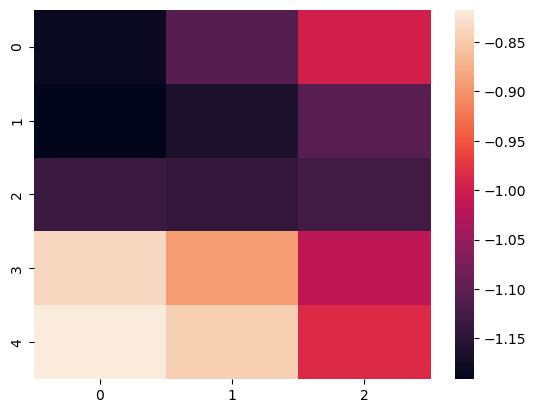

In [47]:
fits_data = np.array(fits_data)

sns.heatmap(fits_data[:,:,0])
plt.show()

# Tree structure

In [ ]:
df['Fol event'] = [[] for _ in range(len(df))]

for i in df['Index']:
    if df['Prev_event'][i] > -1:
        df['Fol event'][df['Prev_event'][i]].append(i)
df

In [ ]:
tree = px.treemap(data_frame=df[df['Index'] < 10], parents=df['Prev event'][df['Index'] < 10])
tree.show()